In [1]:
import spatialdata
import sopa

## Create a SpatialData object

For this tutorial, we use a generated dataset. You can expect a total runtime of a few minutes.

To load your own data, see the commented lines below, or read the [`sopa.io` API](../../api/io).

In [2]:
# The line below creates a toy dataset for this tutorial
# To load your own data, such as MERSCOPE data, you can do `sdata = sopa.io.merscope("/path/to/region_0")`
# For more details, see https://gustaveroussy.github.io/sopa/api/io/
sdata = sopa.io.uniform()

sdata

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (3D points)
└── Shapes
      └── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), transcripts (Points), cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Before starting, we create the variables below that denotes the names of the image and transcripts that we want to use, as displayed in the `SpatialData` object above:

In [3]:
image_key = "image"
points_key = "transcripts" # (ignore this for multiplex imaging)
gene_column = "genes" # (optional) column of sdata[points_key] containing the gene names

## Segmentation

### Option 1: Cellpose

First, we generate the bounding boxes of the patches on which Cellpose will be run. Here, the patches have a width and height of 1500 pixels and an overlap of 50 pixels. We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)). On the toy dataset, this will generate **4** patches.

In [4]:
patches = sopa.segmentation.Patches2D(sdata, image_key, patch_width=1200, patch_overlap=50)
patches.write();

[INFO] (sopa.patches.patches) 4 patches were saved in sdata['sopa_patches']


The following channels are available for segmentation. Choose one or two channels used by Cellpose.

In [5]:
sopa.utils.get_channel_names(sdata[image_key])

array(['DAPI', 'CK', 'CD3', 'CD20'], dtype='<U4')

Then, we initialize the Cellpose model. Here, we run segmentation using DAPI only, and we set the cell diameter to be about `35` pixels:

In [6]:
channels = ["DAPI"]

method = sopa.segmentation.methods.cellpose_patch(diameter=35, channels=channels, flow_threshold=2, cellprob_threshold=-6)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)

# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "tuto.zarr/.sopa_cache/cellpose"

#### Sequential running

If desired, you can run Cellpose sequentially, as in the lines below, but this is slower than the "Parallel running" section below.

In [7]:
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 4/4 [00:37<00:00,  9.44s/it]


#### Parallel running

Here, we show how to run Cellpose in parallel for all the patches. It's up to you to choose the way to parallelize it: for instance, if you have a Slurm cluster, you can run one job per patch.

Below, we run segmentation on each patch, and save the results in a temporary directory (here, `tuto.zarr/.sopa_cache`).
On this example, we performed a "for-loop", so you **should** paralellize this yourself using multiple jobs or multi-threading (see [this discussion](https://github.com/gustaveroussy/sopa/discussions/36) for more details). Note that you can also use our [Snakemake pipeline](https://gustaveroussy.github.io/sopa/tutorials/snakemake/) that will handle the parallelization for you.

In [7]:
# parallelize this for loop yourself (or use the Snakemake pipeline)
for patch_index in range(len(sdata['sopa_patches'])):
    segmentation.write_patch_cells(cellpose_temp_dir, patch_index)

[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.71% (usually due to segmentation artefacts)
[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 1.00% (usually due to segmentation artefacts)
[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 1.37% (usually due to segmentation artefacts)


#### Resolving conflicts

At this stage, you executed 4 times Cellpose (once per patch). Now, we need to resolve the conflict, i.e. where boundaries are overlapping due to segmentation on multiple patches:

In [7]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_boundaries" # name of the key given to the cells in sdata.shapes

sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

Reading patches: 100%|██████████| 4/4 [00:00<00:00, 319.92it/s]
[INFO] (sopa.segmentation.stainings) Found 388 total cells
Resolving conflicts: 100%|██████████| 68/68 [00:00<00:00, 7431.86it/s]
[INFO] (sopa.segmentation.stainings) Added 367 cell boundaries in sdata['cellpose_boundaries']


### Option 2: Baysor

In [4]:
shapes_key = "baysor_boundaries" # the name that we will give to the baysor "shapes"

Baysor needs a config to be executed. You can find official config examples [here](https://github.com/kharchenkolab/Baysor/tree/master/configs).

You can also reuse the Baysor parameter we have defined for each machine, as in our [Snakemake config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config). Note that, our Snakemake config is a `.yaml` file, but the Baysor config should still be a `.toml` file.

For this tutorial, we will use the config below. Instead of a dictionnary, you can also have a `.toml` file and provide `config_path` to the `patchify_transcripts` function.

In [23]:
config = {
    "data": {
        "force_2d": True,
        "min_molecules_per_cell": 10,
        "x": "x",
        "y": "y",
        "z": "z",
        "gene": "genes",
        "min_molecules_per_gene": 0,
        "min_molecules_per_segment": 3,
        "confidence_nn_id": 6
    },
    "segmentation": {
        "scale": 3,  # Important parameter: typical cell diameter, in microns (see our configs)
        "scale_std": "25%",
        "prior_segmentation_confidence": 0,
        "estimate_scale_from_centers": False,
        "n_clusters": 4,
        "iters": 500,
        "n_cells_init": 0,
        "nuclei_genes": "",
        "cyto_genes": "",
        "new_component_weight": 0.2,
        "new_component_fraction": 0.3
    }
}

Then, we generate the bounding boxes of the patches on which Baysor will be run. Here, the patches have a width and height of 3000 microns and an overlap of 50 microns. We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)). On the toy dataset, this will generate **1** patch.

In [24]:
# The cellpose boundaries will be temporary saved here. You can choose a different path
baysor_temp_dir = "tuto.zarr/.sopa_cache/baysor"

patches = sopa.segmentation.Patches2D(sdata, points_key, patch_width=3000, patch_overlap=50)
valid_indices = patches.patchify_transcripts(baysor_temp_dir, config=config)

[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation


[########################################] | 100% Completed | 211.89 ms


[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/baysor


Now, we can run Baysor on each individual patch. It's up to you to choose the way to parallelize it: for instance, if you have a Slurm cluster, you can run one job per patch.

Below, we run segmentation on each patch, and save the results in a temporary directory (here, `tuto.zarr/.sopa_cache/baysor`).
On this example, we performed a "for-loop", so you **should** paralellize this yourself using multiple jobs or multi-threading (see [this discussion](https://github.com/gustaveroussy/sopa/discussions/36) for more details). Note that you can also use our [Snakemake pipeline](https://gustaveroussy.github.io/sopa/tutorials/snakemake/) that will handle the parallelization for you.

> NB: depending on you Baysor installation, you may need to update the `baysor_executable_path` variable to locate the Baysor binary executable

In [25]:
import subprocess

baysor_executable_path = "~/.julia/bin/baysor"

In [ ]:
for patch_index in valid_indices:
    command = f"""
    cd {baysor_temp_dir}/{patch_index}
    {baysor_executable_path} run --save-polygons GeoJSON -c config.toml transcripts.csv
    """
    subprocess.run(command, shell=True)

At this stage, you executed Baysor on each patch. Now, we need to resolve the conflict, i.e. where boundaries are overlapping due to segmentation on multiple patches (although, for this tutorial, there is one patch so there is no conflict):

In [27]:
from sopa.segmentation.transcripts import resolve

resolve(sdata, baysor_temp_dir, gene_column, min_area=10)

[INFO] (sopa.segmentation.transcripts) Cells whose area is less than 10 microns^2 will be removed
Reading transcript-segmentation outputs: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]
Resolving conflicts: 0it [00:00, ?it/s]
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `baysor_boundaries` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.segmentation.transcripts) Added sdata.tables['table'], and 373 cell boundaries to sdata['baysor_boundaries']


## Aggregate

This **mandatory** step turns the data into an `AnnData` object. We can count the transcript inside each cell, and/or average each channel intensity inside each cell boundary.

> NB: Baysor already counts the transcripts inside each cell to create a cell-by-gene table, so you don't need to provide `gene_column`

In [8]:
aggregator = sopa.segmentation.Aggregator(sdata, image_key=image_key, shapes_key=shapes_key)

aggregator.compute_table(gene_column=gene_column, average_intensities=True)

[INFO] (sopa.segmentation.aggregation) Aggregating transcripts over 367 cells


[########################################] | 100% Completed | 102.91 ms


[INFO] (sopa.segmentation.aggregation) Averaging channels intensity over 367 cells with expansion <function expand_radius at 0x322f1ef70>


[########################################] | 100% Completed | 106.06 ms


/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [9]:
sdata

SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (3D points)
├── Shapes
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
│     └── 'sopa_patches': GeoDataFrame shape: (4, 3) (2D shapes)
└── Tables
      └── 'table': AnnData (367, 5)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), transcripts (Points), cellpose_boundaries (Shapes), cells (Shapes), sopa_patches (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Now, `sdata.tables["table"]` is an `AnnData` object.
- If you count the transcripts, then `adata.X` are the raw counts
- If you average the channel intensities, then `adata.X` are the channels intensities
- If you both count the transcript and average the intensities, then `adata.X` are the raw counts, and `adata.obsm["intensities"]` are the channels intensities

## Annotation

#### Option 1: Transcript-based (Tangram)

[Tangram](https://github.com/broadinstitute/Tangram) is a transcript-based annotation that uses an annotated single-cell reference. Let's suppose your reference `AnnData` object is stored in a file called `adata_reference.h5ad` (preferably, keep raw counts), and the cell type is in `adata.obs["cell_type"]`. Then, you can annotate your spatial data as follows:

In [6]:
from sopa.annotation.tangram import tangram_annotate
import anndata

In [ ]:
adata_reference = anndata.read_h5ad("adata_reference.h5ad")

tangram_annotate(sdata, adata_reference, "cell_type")

#### Option 2: Staining-based
For now, our fluorescence-based annotation is very simple. We provide a dictionary where a channel is associated with a population. Then, each cell is associated with the cell type whose corresponding channel is the brightest (according to a certain Z-score). In this tutorial example, we can annotate Tumoral cells, T cells, and B cells:

In [10]:
from sopa.annotation import higher_z_score

marker_cell_dict = {
    "CK": "Tumoral cell",
    "CD20": "B cell",
    "CD3": "T cell"
}

higher_z_score(sdata.tables["table"], marker_cell_dict)

[INFO] (sopa.annotation.fluorescence) Annotation counts: cell_type
Tumoral cell    128
T cell          121
B cell          118
Name: count, dtype: int64


## Pipeline report
You can optionally create an HTML report of the pipeline run (in the example below, we save it under `report.html`). It contains some quality controls for your data.

In [13]:
sopa.io.write_report("report.html", sdata)

[INFO] (sopa.io.report.generate) Writing general_section
[INFO] (sopa.io.report.generate) Writing cell_section
[INFO] (sopa.io.report.generate) Writing channel_section
[INFO] (sopa.io.report.generate) Writing transcripts_section
[INFO] (sopa.io.report.generate) Writing representation_section
[INFO] (sopa.io.report.generate) Computing UMAP on 367 cells
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Visualization

### With the Xenium Explorer

The Xenium Explorer is a software developed by 10X Genomics for visualizing spatial data, and it can be downloaded freely [here](https://www.10xgenomics.com/support/software/xenium-explorer/latest). Sopa allows the conversion to the Xenium Explorer, whatever the type of spatial data you worked on. It will create some files under a new `tuto.explorer` directory:

In [12]:
sopa.io.write("tuto.explorer", sdata, image_key, points_key=points_key, gene_column=gene_column)

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 3 cell categories: region, slide, cell_type
[INFO] (sopa.io.explorer.shapes) Writing 367 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[I

If you have downloaded the Xenium Explorer, you can now open the results in the explorer: `open tuto.explorer/experiment.xenium` (if using a Unix operating system), or double-click on the latter file.

### With spatialdata-plot
[`spatialdata-plot`](https://github.com/scverse/spatialdata-plot) library is a static plotting library for `SpatialData` objects

In [12]:
import spatialdata_plot

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].


INFO     Using matplotlib                                                                                          


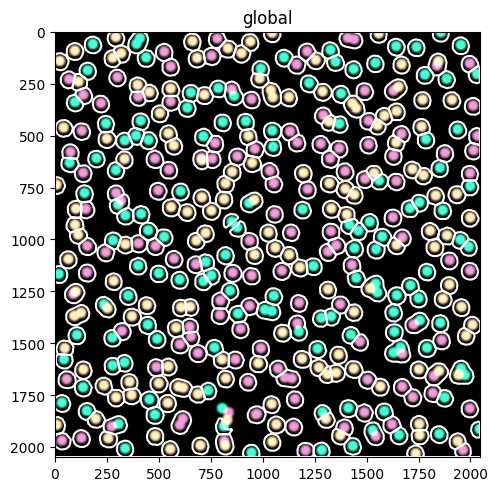

In [13]:
sdata\
    .pl.render_points(size=0.01, color="r", alpha=0.5)\
    .pl.render_images()\
    .pl.render_shapes(shapes_key, outline=True, fill_alpha=0, outline_color="w")\
    .pl.show("global")

## Save your SpatialData object

You can save your `SpatialData` object for later use. This will create a `.zarr` directory.

In [ ]:
sdata.write("tuto.zarr")

You can then open the data with `spatialdata`:

In [ ]:
import spatialdata

spatialdata.read_zarr("tuto.zarr")

## Further analyses

- You can read [this tutorial](../spatial) on spatial statistic and geometric analysis.
- You can use [Squidpy](https://squidpy.readthedocs.io/en/latest/index.html) which operates on both the `SpatialData` object or the `AnnData` object, or use other tools of the `scverse` ecosystem such as [`Scanpy`](https://scanpy.readthedocs.io/en/stable/index.html).
- You can also try the CLI or the Snakemake pipeline of Sopa.